In [2]:
#Imports
#Dataprep
import matplotlib.pyplot as plt
import numpy as np
from nilearn import datasets, plotting, image
from nilearn.maskers import NiftiMapsMasker
from sklearn.decomposition import FastICA
import pandas as pd
import tarfile
import gzip
#GNN required
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch.nn as nn
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GraphConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import SubsetRandomSampler
from sklearn.metrics import accuracy_score

## Data Clean from HCP Data notebook

In [10]:
from ast import literal_eval
import re

In [19]:
data_file = 'Data/data_clean.csv.gz'

with gzip.open(data_file) as filepath:
    data = pd.read_csv(filepath, index_col = 'subject_id', 
            converters = {'netmat' : lambda x : np.array(literal_eval(re.sub('(?<!\[)\s+|[\\n]', ', ', x)))})

In [20]:
data.head()

,Gender,Age,netmat
subject_id,,,
100206,M,26-30,"[[0.0, 0.61676, 9.5727, -5.4959, 0.34639, 3.00..."
100307,F,26-30,"[[0.0, -0.29664, 17.317, -9.0467, -0.28723, 1...."
100408,M,31-35,"[[0.0, 1.6486, 6.6189, -8.8877, 1.4337, 1.006,..."
100610,M,26-30,"[[0.0, -0.90275, 7.7215, -8.3907, 3.3144, 2.93..."
101006,F,31-35,"[[0.0, -0.088768, 9.4979, -10.412, 1.0646, 4.3..."


## Pytorch data preparing

In [21]:
def create_edge_index(num_nodes):
    num_edges = num_nodes * (num_nodes - 1) // 2
    source = []
    target = []
    for i in range(num_nodes):
        # iterate over all other nodes
        for j in range(i+1, num_nodes):
            source.append(i)
            target.append(j)

    edge_index = torch.tensor([source, target], dtype=torch.long)

    return edge_index

# Create an edge index for a fully connected graph with 100 nodes
#edges = create_edge_index(100)
#edges.size()

In [22]:
import torch_geometric.utils as utils

In [23]:
netmats = data['netmat']

In [27]:
example = netmats.iloc[5]
mask = np.triu(abs(example) > 1, k=1)
edge_i = np.transpose(np.nonzero(mask))
t = torch.tensor(edge_i.T)
t.size()

torch.Size([2, 2467])

In [28]:
#Create an undirected edge index from a partial correlation matrix
def edge_gen_treshold(netmat, treshold):
    mask = np.triu(abs(netmat) > treshold, k=1) # using only bottom triangle 
    edge_i = np.transpose(np.nonzero(mask))
    return torch.tensor(edge_i.T)

In [29]:
ex_edges = edge_gen_treshold(example, 1)

In [30]:
import networkx as nx

C:\Users\terho\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\data\storage.py:449: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


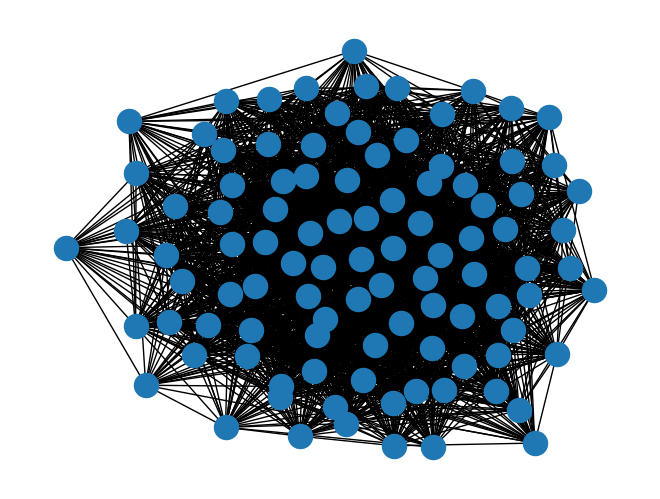

In [31]:
d = Data(x=None, edge_index=ex_edges)
g = torch_geometric.utils.to_networkx(d, to_undirected=True)
nx.draw(g)

In [33]:
data['Gender'] = data['Gender'].replace({"M":0, "F":1})

In [34]:
data['Gender']

subject_id
100206    0
100307    1
100408    0
100610    0
101006    1
         ..
992673    1
992774    0
993675    1
994273    0
996782    1
Name: Gender, Length: 1003, dtype: int64

In [35]:
labels = torch.tensor(data['Gender'].values)
labels

tensor([0, 1, 0,  ..., 1, 0, 1])

In [80]:
netmats = data['netmat']

def collate(data_list):
    graphs, labels = map(list, zip(*data_list))
    return {
        'graph': graphs,
        'label': labels
    }

# Custom dataset class
class CorrelationDataset(torch.utils.data.Dataset):
    def __init__(self, netmats, labels, edges, split_ratio=(0.8, 0.1, 0.1)):
        self.netmats = netmats
        self.labels = labels
        self.edges = edges # premade edge_index
        self.split_ratios = split_ratio
        tot = len(self.netmats)
        train_samples = int(split_ratio[0] * tot)
        val_samples = int(split_ratio[1] * tot)
        
        # Splits
        self.train_indices = list(range(0, train_samples))  # 0 - train_samples
        self.val_indices = list(range(train_samples, train_samples + val_samples))
        self.test_indices = list(range(train_samples + val_samples, tot))
        
    def __len__(self):
        return len(self.netmats)

    def __getitem__(self, idx):
        nmap = torch.tensor(self.netmats.iloc[idx]).float()
        edge_index = edge_gen_treshold(nmap, 1) #Change treshold here
        graph_data = Data(x=nmap, edge_index=edge_index)
        label = self.labels[idx]
        return graph_data, label
    
    def get_split(self, idx):
        if idx in self.train_indices:
            return 'train'
        elif idx in self.val_indices:
            return 'val'
        elif idx in self.test_indices:
            return 'test'
        else:
            raise ValueError('Index not in any split')

# Create the custom dataset
edges = None # No preset
collate_fn = collate
dataset = CorrelationDataset(netmats, labels, edges, split_ratio=(0.8, 0.1, 0.1))
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.train_indices), collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.val_indices), collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.test_indices), collate_fn=collate_fn)

In [81]:
test = iter(train_loader)
print(next(test))

{'graph': [Data(x=[100, 100], edge_index=[2, 2828])], 'label': [tensor(0)]}


In [82]:
class GCN(nn.Module):
    def __init__(self,):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(100, 150)
        self.bn1 = nn.BatchNorm1d(150)
        self.conv2 = GCNConv(150, 50)
        self.bn2 = nn.BatchNorm1d(50)
        self.classifier = Linear(50, 1)

    def forward(self, data):
        data = data['graph'][0]
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.tanh(x)
        x = nn.Dropout(p=0.75)(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = torch.tanh(x)
        x = nn.Dropout(p=0.75)(x)
        x = self.classifier(x).mean(dim=0)
        x = torch.sigmoid(x)
        return x
    

In [83]:
model = GCN()
print(model)

GCN(
  (conv1): GCNConv(100, 150)
  (bn1): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(150, 50)
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Linear(in_features=50, out_features=1, bias=True)
)


In [84]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [85]:
test = iter(train_loader)
print(next(test))

{'graph': [Data(x=[100, 100], edge_index=[2, 2630])], 'label': [tensor(0)]}


In [86]:
ah = model(next(test))

In [87]:
criterion(ah.double(),torch.tensor([0]).double())

tensor(0.6422, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)

In [88]:
def train(model, data_loader, device, loss_fn, optimizer):
    model.train()
    total_loss = 0
    num_true = 0
    num_true_guesses = 0
    for d in data_loader:
        m = d['graph'][0]
        m = m.to(device)
        label = d['label'][0]
        optimizer.zero_grad()
        out = model(d).squeeze()
        loss = loss_fn(out.float(), label.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = (out.double() > 0.5).float()
        if pred == label.float():
            num_true += 1
        if pred == 1:
            num_true_guesses += 1
    return total_loss, num_true, num_true_guesses

def eval(model, loader, device):
    model.eval()
    cor = 0
    tot = 0
    for d in loader:
        with torch.no_grad():
            out = model(d)
            pred = (out.float() > 0.5).float()
        y = d['label'][0]
        cor += (pred == y).sum()
        tot += pred.shape[0]
    return cor/tot
        

Epoch: 1/30, Loss: 555.0806082189083, Avg Loss: 0.692, Train: 64.34%, Validation: 58.00%, Num Correct: 425, Num True: 713 
Epoch: 2/30, Loss: 551.7597963809967, Avg Loss: 0.688, Train: 66.21%, Validation: 64.00%, Num Correct: 441, Num True: 653 
Epoch: 3/30, Loss: 537.7126896083355, Avg Loss: 0.670, Train: 69.33%, Validation: 69.00%, Num Correct: 476, Num True: 614 
Epoch: 4/30, Loss: 493.1695710718632, Avg Loss: 0.615, Train: 69.20%, Validation: 67.00%, Num Correct: 551, Num True: 479 
Epoch: 5/30, Loss: 462.9717303067446, Avg Loss: 0.577, Train: 66.46%, Validation: 62.00%, Num Correct: 578, Num True: 462 
Epoch: 6/30, Loss: 431.9855725429952, Avg Loss: 0.539, Train: 71.32%, Validation: 73.00%, Num Correct: 584, Num True: 448 
Epoch: 7/30, Loss: 419.97773531638086, Avg Loss: 0.524, Train: 72.82%, Validation: 73.00%, Num Correct: 591, Num True: 447 
Epoch: 8/30, Loss: 396.88462680764496, Avg Loss: 0.495, Train: 69.33%, Validation: 66.00%, Num Correct: 617, Num True: 451 
Epoch: 9/30, L

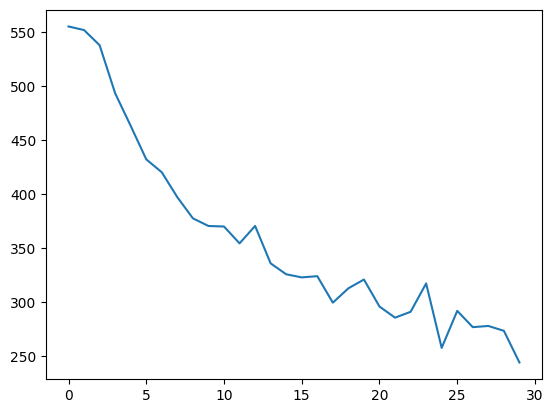

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GCN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = nn.BCELoss()
losses = []

num_epochs = 30
for epoch in range(num_epochs):
    loss, num_true, num_true_guesses = train(model, train_loader, device, criterion, optimizer)
    train_results = eval(model, train_loader, device)
    val_results = eval(model, val_loader, device)
    losses.append(loss)
    avg_loss = loss / len(train_loader)
    print(f'Epoch: {epoch + 1}/{num_epochs}, '
          f'Loss: {loss}, '
          f'Avg Loss: {avg_loss:.3f}, '
          f'Train: {100 * train_results:.2f}%, '
          f'Validation: {100 * val_results:.2f}%, '
          f'Num Correct: {num_true}, '
          f'Num True: {num_true_guesses} ')
    
    
plt.plot(losses)
plt.show()

In [49]:
"""
#old approach 
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    num_true = 0
    num_true_guesses = 0
    for data in train_loader:
        m = data['graph'][0]
        label = data['label'][0]
        optimizer.zero_grad()
        out = model(data).squeeze()
        loss = criterion(out.double(), label.double())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if out.double() == label.double():
            num_true += 1
        if out.double() == 1:
            num_true_guesses += 1
            
    accuracy = 100 * num_true / len(train_loader)
    average_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.8f}, Training Accuracy: {accuracy:.8f}%, num_true: {num_true}, true_guesses: {num_true_guesses}')
"""

"\n#old approach \nnum_epochs = 3\nfor epoch in range(num_epochs):\n    model.train()\n    total_loss = 0\n    num_true = 0\n    num_true_guesses = 0\n    for data in train_loader:\n        m = data['graph'][0]\n        label = data['label'][0]\n        optimizer.zero_grad()\n        out = model(data).squeeze()\n        loss = criterion(out.double(), label.double())\n        loss.backward()\n        optimizer.step()\n        total_loss += loss.item()\n        if out.double() == label.double():\n            num_true += 1\n        if out.double() == 1:\n            num_true_guesses += 1\n            \n    accuracy = 100 * num_true / len(train_loader)\n    average_loss = total_loss / len(train_loader)\n    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.8f}, Training Accuracy: {accuracy:.8f}%, num_true: {num_true}, true_guesses: {num_true_guesses}')\n"

In [46]:
for parameter in model.parameters():
    print(len(parameter))

300
300
250
250
100
100
1
1


In [47]:
i = 0
for parameter in model.parameters():
    if i == 1:
        matrix = parameter.data.numpy()
    i += 1

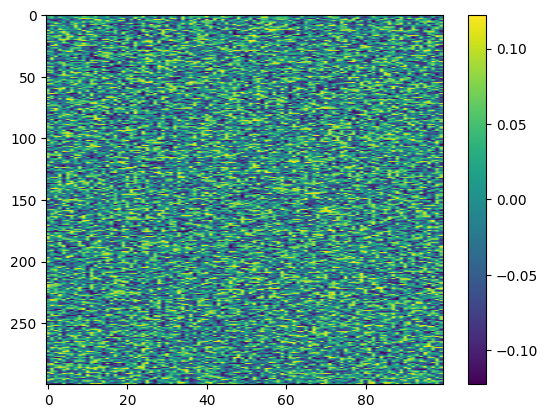

In [48]:
plt.imshow(matrix, aspect='auto')
plt.colorbar()